In [33]:
%matplotlib inline
%pylab inline

from functools import partial

import menpo.io as mio
from menpo.feature import fast_dsift, double_igo, no_op

from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images, print_dynamic, plot_graph

from menpofit.aam import (
    HolisticAAM, LucasKanadeAAMFitter, 
    holistic_sampling_from_scale,  holistic_sampling_from_step)
from menpofit.aam.algorithm.lk_alabort_arxiv2015 import (
    SSDForwardGaussNewtonSimultaneous,
    SSDForwardGaussNewtonAlternated,
    SSDInverseGaussNewtonSimultaneous,
    SSDInverseGaussNewtonAlternated,
    SSDAsymmetricGaussNewtonSimultaneous,
    SSDAsymmetricGaussNewtonAlternated,
    SSDBidirectionalGaussNewtonSimultaneousCombined,
    SSDBidirectionalGaussNewtonSimultaneous,
    SSDBidirectionalGaussNewtonAlternated,
    SSDBidirectionalGaussNewtonAlternatedCombined)
from menpofit.visualize import visualize_fitting_result, plot_ced

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Load training data

In [2]:
training_images = []
for i in mio.import_images('/Users/joan/PhD/DataBases/faces/lfpw/trainset/', 
                           verbose=True, max_images=None):
    i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_66)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    training_images.append(i)

Importing assets: [==========] 100% (811/811) - done.                           


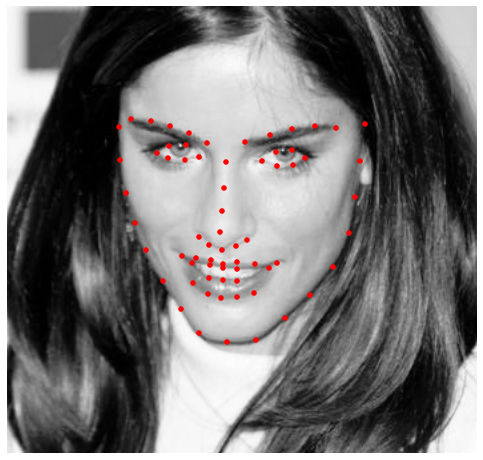

In [3]:
visualize_images(training_images)

## Load test data

In [4]:
test_images = []
for i in mio.import_images('/Users/joan/PhD/DataBases/faces/lfpw/testset/', 
                           verbose=True, max_images=10):    
    i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_66)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    test_images.append(i)

Importing assets: [==========] 100% (10/10) - done.                             


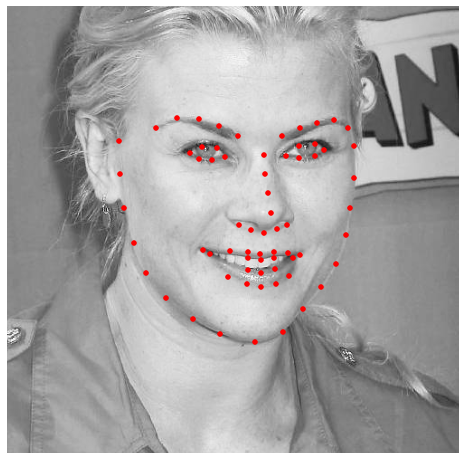

In [5]:
visualize_images(test_images)

## Build Active Appearance Models

In [34]:
features = no_op
diagonal = 200
scales = (0.5, 1)
max_shape_components= 25
max_appearance_components = None

#### AAM

In [35]:
aam = HolisticAAM(
    training_images, 
    group='ibug_face_66', 
    verbose=True,
    features=features,
    diagonal=diagonal,
    scales=scales,
    max_shape_components=max_shape_components,
    max_appearance_components=max_appearance_components)

Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Done


## Fit Active Appearance Models

In [68]:
sampling_step = [2, 2]
n_shape = [3, 12]
n_appearance = [25, 50]
l = 0.5

#### AAM Fitter

In [69]:
fitter_1 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDForwardGaussNewtonSimultaneous),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_2 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDForwardGaussNewtonAlternated),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_3 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDInverseGaussNewtonSimultaneous),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_4 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDInverseGaussNewtonAlternated), 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_5 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDAsymmetricGaussNewtonSimultaneous), 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_6 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDAsymmetricGaussNewtonAlternated),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_7 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDBidirectionalGaussNewtonSimultaneous), 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_8 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDBidirectionalGaussNewtonSimultaneousCombined), 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_9 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDBidirectionalGaussNewtonAlternated),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_10 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDBidirectionalGaussNewtonAlternatedCombined),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

#### Fitting loop

In [70]:
fitters = [fitter_1,
           fitter_2,
           fitter_3,
           fitter_4,
           fitter_5,
           fitter_6,
           fitter_7,
           fitter_8,
           fitter_9,
           fitter_10]

n_fitters = len(fitters)
legend_entries=['ini', 'f_s', 'f_a', 'i_s', 'i_a', 'a_s', 'a_a', 'b_s', 'b_s_c', 'b_a', 'b_a_c']

fitters_results = []

for j, i in enumerate(test_images):
    
    np.random.seed(j)
    
    gt_s = i.landmarks['ibug_face_66'].lms
    s = fitters[0].noisy_shape_from_shape(gt_s, noise_percentage=0.02)

    for fitter in fitters:
        
        fr = fitter.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
        fr.downscale = 0.5
        fitters_results.append(fr)
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

## Visualize Results

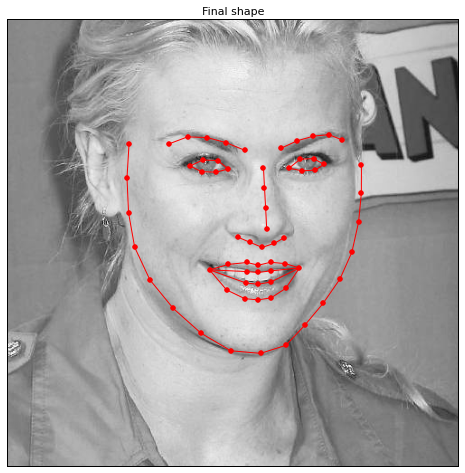

In [71]:
visualize_fitting_result(fitters_results[2::n_fitters])

In [72]:
errors = [[fr.initial_error() for fr in fitters_results[::n_fitters]]]

for j in range(n_fitters):
    errors.append([fr.final_error() for fr in fitters_results[j::n_fitters]])

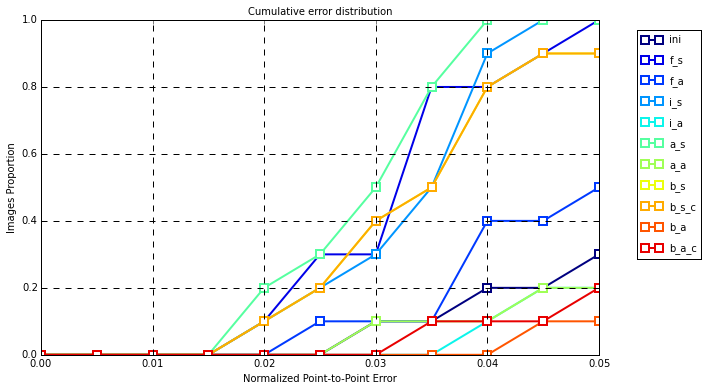

In [73]:
plot_ced(errors, legend_entries=legend_entries)

In [74]:
for j, e in enumerate(errors):
    print legend_entries[j], '\tmean:', np.mean(e), '\tstd:', np.std(e), '\tmedian:', np.median(e)

ini 	mean: 0.0559351488099 	std: 0.0139955372836 	median: 0.0592577718882
f_s 	mean: 0.0308754032285 	std: 0.00777797353214 	median: 0.0310466508621
f_a 	mean: 0.0588784266939 	std: 0.02930416124 	median: 0.0502882166872
i_s 	mean: 0.0326927046118 	std: 0.00650411585257 	median: 0.0349212899579
i_a 	mean: 0.0932760960034 	std: 0.0494638441268 	median: 0.0773623146523
a_s 	mean: 0.0282736741879 	std: 0.00671168765353 	median: 0.0294611330258
a_a 	mean: 0.0615946049947 	std: 0.0207478443555 	median: 0.0540907674481
b_s 	mean: 0.0337048354997 	std: 0.00887379302547 	median: 0.0350630946152
b_s_c 	mean: 0.0336792861328 	std: 0.00886835121327 	median: 0.0352133045236
b_a 	mean: 0.0909813153987 	std: 0.0454725611276 	median: 0.0683672898963
b_a_c 	mean: 0.083233078351 	std: 0.0408106063711 	median: 0.072924861019


In [75]:
mean_errors = []
median_errors = []
for j in range(n_fitters):
    errors = np.asarray([fr.errors() for fr in fitters_results[j::n_fitters]])
    mean_errors.append(np.mean(errors, axis=0))
    median_errors.append(np.median(errors, axis=0))

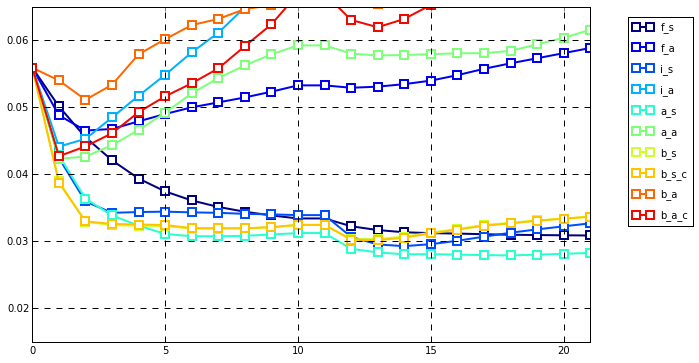

In [76]:
plot_graph(np.arange(0, 22), 
           mean_errors, 
           y_axis_limits=(0.015, 0.065),
           legend_entries=legend_entries[1:])

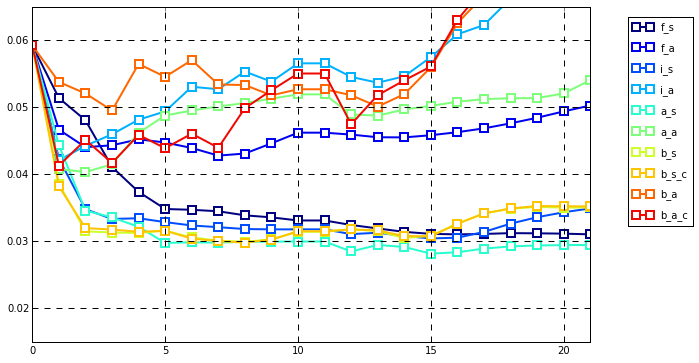

In [77]:
plot_graph(np.arange(0, 22), 
           median_errors, 
           y_axis_limits=(0.015, 0.065),
           legend_entries=legend_entries[1:])

In [ ]:
%timeit fr = fitter_1.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_2.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_4.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_5.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_6.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 

In [20]:
# import line_profiler
# import IPython

# ip = IPython.get_ipython()
# ip.define_magic('lprun', line_profiler.magic_lprun)

In [21]:
# %lprun -f ProjectOutAsymmetricGaussNewton._solve fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=2) 